In [2]:
import pandas as pd
import numpy as np
import statistics as stat
import warnings
warnings.filterwarnings('ignore')
df= pd.read_csv('/content/DFORE168f2.csv')
gf= pd.read_csv('/content/1H21 GRPM.csv')

In [3]:
df['AvgAge']=pd.to_numeric(df.AvgAge, errors='coerce')

In [4]:
gf['grpmImputed']=pd.to_numeric(gf.GRPM,errors = 'coerce')
p10= gf.grpmImputed.describe(percentiles=[.1, .25, .75, .95]).loc['10%']
p95= gf.grpmImputed.describe(percentiles=[.1, .25, .75, .95]).loc['95%']
p50= gf.grpmImputed.describe(percentiles=[.1, .25, .75, .95]).loc['50%']
gf.grpmImputed.fillna(p50, inplace= True)
gf["grpmImputed"] = np.where(gf["grpmImputed"] <p10, p10,gf['grpmImputed'])
gf["grpmImputed"] = np.where(gf["grpmImputed"] >p95, p95,gf['grpmImputed'])

In [5]:
df1= df.merge(gf, how= 'left', left_on= 'as400id', right_on= 'AS400ID')
# Select numeric columns.
a = df1.select_dtypes('number')
# Select string and object columns.
b = df1.select_dtypes('object')

In [6]:
# Fill numeric columns with mean.
df1[a.columns] = a.fillna(a.median())
# Fill object columns with mode.
df1[b.columns] = b.fillna(b.agg(lambda x: x.mode().values[0]))

In [7]:
a.median()

as400id        4.273518e+06
AvgAge         4.288000e+01
latitude       3.677669e+01
longitude     -9.388228e+01
InstallCap     8.000000e+00
users          3.700000e+01
AS400ID        4.272923e+06
Washers        4.000000e+00
Dryers         4.000000e+00
Machines       8.000000e+00
grpmImputed    5.946000e+01
dtype: float64

In [8]:
b.agg(lambda x: x.mode().values[0])

AccountName_x            COUNTRY PLACE APTS
BranchName                   So. California
Region                                 West
IndustrySubType                  Apartments
PropertyClass                       Class C
AccountClassification                   SSS
AccountName_y            COUNTRY PLACE APTS
Gross Revenue                             0
GRPM                                #DIV/0!
dtype: object

In [9]:
conditions = [
    (df1['AvgAge'] <= 30),
    (df1['AvgAge'] > 30) & (df['AvgAge'] <= 60),
    (df1['AvgAge'] >  60)
    ]
values = ['Y', 'M', 'O']
df1['AgeBand'] = np.select(conditions, values)
df1['Machines_dec']= pd.qcut(df1['Machines'], 4, labels=np.arange(4, 0, -1))
df1['grpmImputed_dec']= pd.qcut(df1['grpmImputed'], 4, labels=np.arange(4, 0, -1))

In [20]:
df1.shape

(10358, 24)

In [10]:
df1.head()

,as400id,AccountName_x,BranchName,Region,IndustrySubType,AvgAge,PropertyClass,latitude,longitude,InstallCap,users,AS400ID,AccountClassification,Washers,Dryers,AccountName_y,Gross Revenue,Machines,GRPM,grpmImputed,AgeBand,Machines_dec,grpmImputed_dec
0,2620019,CRICKET HOLLOW APTS,Austin,West,Apartments,39.89,Class D,30.284361,-97.726791,41,176,2620019.0,SSS,19.0,22.0,CRICKET HOLLOW APTS,"9,973",41.0,40.54,40.54,M,1,3
1,7600582,OPPORTUNITY PAVILLION,Kansas City,West,Apartments,59.56,Class B,38.912312,-94.513789,8,2,7600582.0,SSS,2.0,2.0,OPPORTUNITY PAVILLION,"4,516",4.0,188.17,140.00,M,4,1
2,400809,BARONY PLACE APTS,Charlotte,East,Apartments,58.23,Class C,32.865696,-79.979737,0,5,400809.0,SSS,2.0,2.0,BARONY PLACE APTS,24,4.0,01.00,7.80,M,4,4
3,6812516,600 I ST,Sacramento,West,Apartments,61.68,Class C,38.582596,-121.497650,24,17,6812516.0,SSS,12.0,12.0,600 I ST,"5,386",24.0,37.40,37.40,O,1,4
4,2720098,NORMANDY APARTMENTS,Nashville,East,Apartments,43.98,Class C,35.112744,-85.294039,15,98,2720098.0,SSS,8.0,8.0,NORMANDY APTS,"8,826",16.0,91.94,91.94,M,1,1


In [11]:
features= ['BranchName', 'PropertyClass', 'Machines_dec', 'grpmImputed_dec', 'AgeBand']
df1['AllFeatures']= df1[features].astype(str).sum(axis=1)

In [ ]:
def add_campaignflag(df, dec='AllFeatures', splits=[.75,.25]):
  np.random.seed(42)
#   df['dec']= pd.qcut(df[col], 10, labels=np.arange(10, 0, -1))
  dfs=[]
  for i,d in enumerate(list(df[dec].unique())):
    df1= df.loc[df[dec]==d]
#     print(d, len(df1))
    ixs= np.arange(df1.shape[0])
    np.random.shuffle(ixs)
    # print(i,d,len(ixs))
    df1['camp_flag']= None
    start=0
    for i,s in enumerate(splits):
      stop= start+int(round(s*len(df1),0))
      df1.loc[:,'camp_flag'].iloc[start:stop]= 'split_'+str(i)
      start = stop
#       print(i,d,stop,start,df1.camp_flag.value_counts())
#     print(d,df1.camp_flag.value_counts())
    dfs.append(df1)
  df4= pd.concat(dfs, axis=0)
  return(df4)

In [ ]:
df2=add_campaignflag(df1)

In [ ]:
df2.camp_flag.value_counts(normalize=False)

Test       1971
Control     436
Name: camp_flag, dtype: int64

In [ ]:
df2['camp_flag']= df2.camp_flag.map({'split_0': 'Test', 'split_1':'Control'})

In [ ]:
df2.head()

,as400id,AccountName_x,BranchName,Region,Industry,IndustrySubType,LineOfBusiness,AvgAge,PropertyClass,mcCnt,roomNbr,AS400ID,AccountClassification,Washers,Dryers,AccountName_y,Gross Revenue,Machines,GRPM,grpmImputed,AgeBand,mcCnt_dec,grpmImputed_dec,AllFeatures,camp_flag
0,1500450,CASA GRANDE VILLAGE,Dallas,West,Multi-Housing,Apartments,Laundry Facilities,44.41,Class C,12,1,1500450.0,SSS,6.0,6.0,CASA GRANDE VILLAGE,"4,896",12.0,68.00,68.00,M,2,2,Class CMDallas22,Test
81,1520369,DOGWOOD APARTMENTS,Dallas,West,Multi-Housing,Apartments,Laundry Facilities,44.46,Class C,12,1,1520369.0,SSS,6.0,6.0,DOGWOOD APTS,"5,032",12.0,69.89,69.89,M,2,2,Class CMDallas22,Test
103,1520531,THE GLENBROOK APTS,Dallas,West,Multi-Housing,Apartments,Laundry Facilities,41.26,Class C,8,1,1520531.0,SSS,4.0,4.0,THE GLENBROOK APTS,"2,458",8.0,51.21,51.21,M,2,2,Class CMDallas22,Test
166,1521203,FOX CREEK APTS,Dallas,West,Multi-Housing,Apartments,Laundry Facilities,42.40,Class C,8,1,1521203.0,SSS,4.0,4.0,FOX CREEK APTS,"3,275",8.0,68.23,68.23,M,2,2,Class CMDallas22,Test
1383,54659,INDEPENDENCE MANOR II-NACOGDOCHES,Dallas,West,Multi-Housing,Apartments,Laundry Facilities,43.75,Class C,8,1,54659.0,SSS,4.0,4.0,INDEPENDENCE MANOR II-NACOGDOCHES,"2,784",8.0,58.00,58.00,M,2,2,Class CMDallas22,Test


# Active Users

In [ ]:
df3= pd.read_csv('/content/DFORE125D2.csv')

In [ ]:
df3.shape

(2610, 9)

In [ ]:
df3.users.describe()

count    2610.000000
mean        5.370498
std        11.872239
min         0.000000
25%         1.000000
50%         3.000000
75%         6.000000
max       265.000000
Name: users, dtype: float64

In [ ]:
p10= df3.users.describe(percentiles=[.1, .25, .75, .95]).loc['10%']
p95= df3.users.describe(percentiles=[.1, .25, .75, .95]).loc['95%']

In [ ]:
df3["users"] = np.where(df3["users"] <p10, p10,df3['users'])
df3["users"] = np.where(df3["users"] >p95, p95,df3['users'])

In [ ]:
df2.merge(df3, left_on='as400id', right_on='as400id').groupby('camp_flag').agg({'as400id': 'nunique', 'users': 'sum'})

,as400id,users
camp_flag,,
Control,431,1923.0
Test,1939,9053.0


In [ ]:
431/(431+1939)

0.18185654008438817

In [ ]:
1923/(1923+11566)

0.14256060493735637

In [ ]:
df3.columns

Index(['as400id', 'AccountName', 'BranchName', 'Region', 'IndustrySubType',
       'AvgAge', 'PropertyClass', 'InstallCap', 'users'],
      dtype='object')

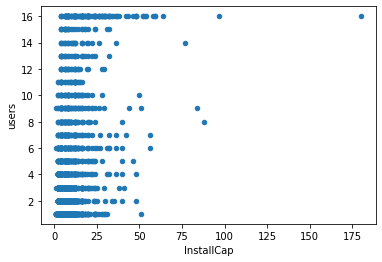

In [ ]:
df3.plot('InstallCap', 'users', kind= 'scatter')

# Export

In [ ]:
df2.to_csv('as400MultifamilySplitwithFeaturesAUDIT0729.csv', index=False)

In [ ]:
df2.loc[df2.camp_flag== 'Test', 'as400id'].to_csv('test.csv')

In [ ]:
df2.loc[df2.camp_flag== 'Control', 'as400id'].to_csv('control.csv')

# DFORE-127 

 New_to_cohort

In [ ]:
df4= pd.read_csv('/content/D127D1.csv')

In [ ]:
df4.columns

Index(['cohort_flag', 'branch_id', 'as400id', 'latitude', 'longitude',
       'accountname', 'address1', 'address2', 'city', 'state', 'zipcode',
       'New_to_cohort'],
      dtype='object')

In [ ]:
df4.as400id.value_counts()[df4.as400id.value_counts()> 1]

Series([], Name: as400id, dtype: int64)

In [ ]:
df4.drop_duplicates('as400id', keep='first', inplace=True)

In [ ]:
df2df2.loc[df2.camp_flag=='Test', 'as400id']

0       1500450
81      1520369
103     1520531
166     1521203
1383      54659
         ...   
2393      63009
2395      85085
2397      64395
2398      69700
2404    7401051
Name: as400id, Length: 1971, dtype: int64

In [ ]:
df4['New_to_cohort']= 'Yes'

In [ ]:
df4.loc[df4.as400id.isin(df2.loc[df2.camp_flag=='Test', 'as400id']), 'New_to_cohort']= 'No'

In [ ]:
df4.loc[df4.as400id.isin(df2.loc[df2.camp_flag=='Control', 'as400id']), 'New_to_cohort']= 'No'

In [ ]:
df4.groupby(['cohort_flag', 'New_to_cohort'])['as400id'].size()

cohort_flag  New_to_cohort
control      No                477
             Yes                83
test         No               1929
             Yes               309
Name: as400id, dtype: int64

In [ ]:
df4.loc[df4.cohort_flag== 'test'].to_csv('LAMtest08032021.csv', index= False)

In [ ]:
df4.loc[df4.cohort_flag== 'control'].to_csv('LAMcontrol08032021.csv', index= False)